In [2]:
from astropy.io import fits
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as ima


# Parte II 

En el paper Sirianni et al. (2005) se calibraron las magnitudes de F555W al filtro V y F814W al filtro I. Posteriormente se procede a realizar un diagrama de Hess en dos tipos.

<Container object of 3 artists>

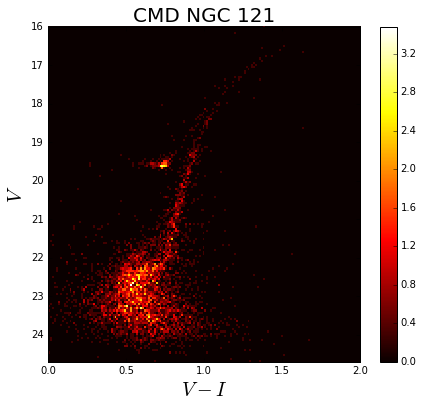

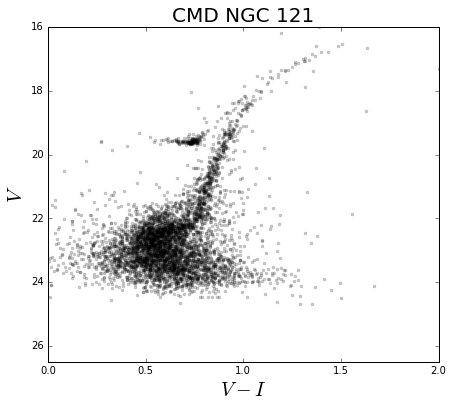

In [3]:
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii   
%matplotlib inline

#----------------------f555-------------------------------
fil = open("./f555.cat","r") 
body = ascii.read(fil)

RA1 = np.array(body["ALPHA_J2000"])
DEC1 = np.array(body["DELTA_J2000"])
MAG1 = np.array(body["MAG_APER"]) + 2.5*np.log10(0.656) - 0.101  # Mag_source - Mag_ap - Mag_rd
MAG_ERR1 = np.array(body["MAGERR_APER"])

fil.close()

#----------------------f814-------------------------------
fil = open("./f814.cat","r") 
body = ascii.read(fil)

RA2 = np.array(body["ALPHA_J2000"])
DEC2 = np.array(body["DELTA_J2000"])
MAG2 = np.array(body["MAG_APER"]) + 2.5*np.log10(0.534) - 0.056 # Mag_source - Mag_ap - Mag_rd
MAG_ERR2 = np.array(body["MAGERR_APER"])

fil.close()

c = SkyCoord(ra=RA2*u.degree, dec=DEC2*u.degree)  
catalog = SkyCoord(ra=RA1*u.degree, dec=DEC1*u.degree)  
idx, d2d, d3d = match_coordinates_sky(c, catalog)

MAG_COLOR = []
MAG_V = []
MAG_I = []

for i in range(0,len(RA2)):
    V_o = MAG1[idx[i]]
    I_o = MAG2[i]
    V = V_o
    I = I_o
    for i in range(0,11):
        color = V - I
        if color < 0.6:
            V = V_o + 25.25 - 0.09*color + 0.034*color**2
        else:
            V = V_o + 25.275 - 0.124*color + 0.018*color**2
        if color  < 0.1:
            I = I_o + 24.837 +0.06*color - 0.099*color**2
        else:
            I = I_o + 24.838 + 0.001*color + 0.013*color**2
    
    MAG_COLOR.append(color)
    MAG_V.append(V)
    MAG_I.append(I)

plt.figure(figsize=(7,6))
plt.title("CMD NGC 121",size=20)
plt.xlabel('$V-I$',size=20)
plt.ylabel('$V$',size=20)
plt.hist2d(MAG_COLOR, MAG_V, bins=160,cmap = "hot",normed=True,range=[[0, 2], [np.min(MAG_V),np.max(MAG_V)]])
plt.colorbar()
plt.xlim(0,2)
plt.ylim(np.min(MAG_V),np.max(MAG_V))
plt.gca().invert_yaxis()

plt.figure(figsize=(7,6))
plt.xlim(0,2)
plt.ylim(16,26.5)
plt.gca().invert_yaxis()
plt.title("CMD NGC 121",size=20)
plt.xlabel('$V-I$',size=20)
plt.ylabel('$V$',size=20)
plt.errorbar(MAG_COLOR,MAG_V, fmt='.',color='k', alpha = 0.2)


Posterior a calibrar las imagenes en los filtros V e I se ajusta una curva a los datos en la parte de la secuencia principal, el turn-off y la rama de las gigantes sin incorporar la rama horizontal.

<Container object of 3 artists>

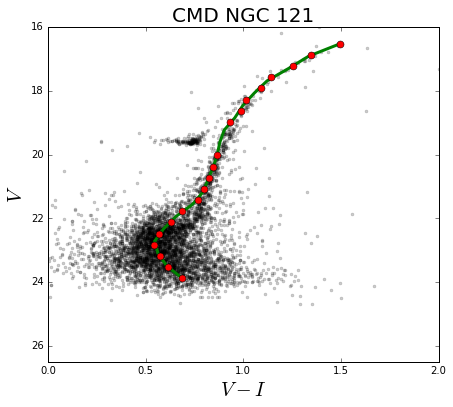

In [26]:

plt.figure(figsize=(7,6))
plt.xlim(0,2)
plt.ylim(16,26.5)
plt.gca().invert_yaxis()
plt.title("CMD NGC 121",size=20)
plt.xlabel('$V-I$',size=20)
plt.ylabel('$V$',size=20)
plt.errorbar(MAG_COLOR,MAG_V, fmt='.',color='k', alpha = 0.2)


ap = []
i = np.min(MAG_V)
bin_w = 0.35
while i < np.max(MAG_V):
    aux = []
    for element in MAG_V:
        if element > i and element < i + bin_w:
            aux.append([(2*i + bin_w)/2,MAG_COLOR[MAG_V.index(element)]])
    if aux != []:
        ap.append(np.array(aux))
    i += bin_w

ap1 = ap[11:]
ap2 = ap[:9]
ap1 = ap1[:-2]
ap2 = ap2[1:]
tot = np.concatenate((ap1,ap2),axis=0)
x = []
y = []
for element in tot:
    color = element[:,1]
    mediana = np.median(color)
    x.append(mediana)
    mag = element[:,0]
    y.append(np.extract(mediana,mag)[0])

x = np.array(x)
y = np.array(y)    

f = interp1d(y, x, kind='cubic')
xnew = np.linspace(np.min(y), np.max(y), 20, endpoint=True)
plt.plot(f(xnew), xnew, 'g', lw=3)
plt.errorbar(x,y, fmt='o',color='r',markersize = 7)

Para obtener el gráfico anterior, se iteró en el eje y con un ancho de bin de 0.35 y se obtenia la mediana de los datos en ese bin, se deja de lado el bin que contiene a la rama horizontal y se realiza un spline de orden cúbico.

## *Isochrones*

Despues utilizando la librería *isochrones* y valores de la edad, metalicidad y módulo de distancia encontrados en **NED** más específico en el paper referenciado ahí, Andrew E. Dolphin et al. 2001. Estos son:

1. Edad = 10.6 Gyr.
2. Metalicidad = -1.03 Fe/H
3. Módulo de distancia = 18.94 mag

Se obtiene la isocrona que comparada con los datos tomados y al ridge line queda como:

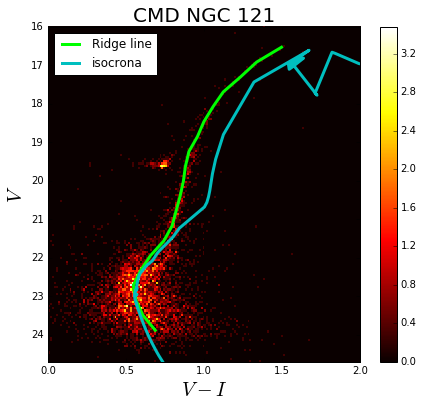

In [14]:
from isochrones.dartmouth import Dartmouth_Isochrone

def isoc(age, feh, mod_dis):
    iso = Dartmouth_Isochrone(bands=['V','I'])
    model = iso.isochrone(age=np.log10(age), feh=feh, dm=0.001)
    model_V = model.V_mag + mod_dis 
    model_I = model.I_mag + mod_dis 
    model_VI = model_V - model_I
    return model_V, model_VI

model_V, model_VI = isoc(10.6*10**9,-1.03,18.94)
                
plt.figure(figsize=(7,6))
plt.xlim(0,2)
plt.ylim(16,26.5)
plt.gca().invert_yaxis()
plt.title("CMD NGC 121",size=20)
plt.xlabel('$V-I$',size=20)
plt.ylabel('$V$',size=20)

plt.hist2d(MAG_COLOR, MAG_V, bins=160,cmap = "hot",normed=True,range=[[0, 2], [np.min(MAG_V),np.max(MAG_V)]])
plt.colorbar()
plt.xlim(0,2)
plt.ylim(np.min(MAG_V),np.max(MAG_V))
plt.gca().invert_yaxis()

plt.plot(f(xnew), xnew, 'lime', lw=3,label="Ridge line")

plt.plot(model_VI,model_V,'c',lw = 3, label="isocrona")

plt.legend(loc='upper left')


Ahora bien, es claro ver que la isocrona ajusta un poco bien en la parte de la secuencia principal, pero en la parte de las gigantes el ajuste no es bueno, esto podría deberse a que los datos encontrados en la literatura no esten del todo buenos, pues recordemos que el paper fue escrito el año 2001.

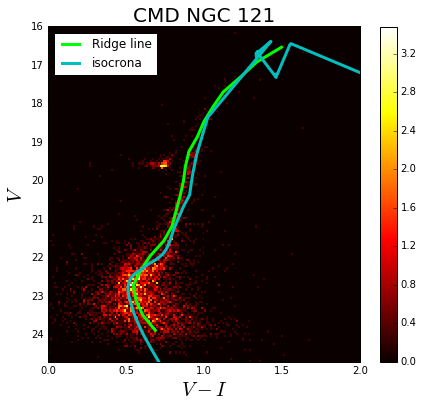

In [24]:
plt.figure(figsize=(7,6))
plt.xlim(0,2)
plt.ylim(16,26.5)
plt.gca().invert_yaxis()
plt.title("CMD NGC 121",size=20)
plt.xlabel('$V-I$',size=20)
plt.ylabel('$V$',size=20)

model_V, model_VI = isoc(11.5*10**9,-1.6,18.97)

plt.hist2d(MAG_COLOR, MAG_V, bins=160,cmap = "hot",normed=True,range=[[0, 2], [np.min(MAG_V),np.max(MAG_V)]])
plt.colorbar()
plt.xlim(0,2)
plt.ylim(np.min(MAG_V),np.max(MAG_V))
plt.gca().invert_yaxis()

plt.plot(f(xnew), xnew, 'lime', lw=3,label="Ridge line")

plt.plot(model_VI,model_V,'c',lw = 3, label="isocrona")

plt.legend(loc='upper left')


Iterando los valores de Edad, Metalicidad y Módulo de distancia, obtenemos los valores de:

1. Edad = 11.5 Gyr.
2. Metalicidad = -1.6 Fe/H.
3. Módulo de distancia = 18.97 mag.

El método para obtener esos valores no fue el más robusto, tan solo se iteraba y se veía al "ojo" cual ajustaba mejor. Se recomienda que esto se haga con algún método estadístico, tal como el método de Monte Carlo, sin embargo, la velocidad de este procesador no permite un análisis rápido debido a la cantidad de iteraciones y a la lenta función de *Dartmouth_Isochrone.isochrone*. Además existe una probabilidad que los datos no hayan sido calibrados correctamente, a pesar de que esto se hizo rigurosamente, la posición de la isocrona en la secuencia principal resalta esta teoría. 